In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data.dataloader import DataLoader

from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
import torchvision.transforms as T

from tensorboardX import SummaryWriter
writer = SummaryWriter()

## 1. 데이터 불러오기 & 전처리

딥러닝에서는 오버피팅 문제가 많이 발생함   
여러가지 해결 방법을 활용해야함

이미지를 변형하는 기법을 활용한다
- 이미지를 자르는 : RandomCrop 활용
- 이미지 좌우 반전 : RandomHorizontalFlip

드랍아웃 방법
- 신경망의 일부 뉴런(노드)을 무작위로 비활성화(drop-out)시키는 방법 : nn.Dropout(p)

In [41]:
MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.247, 0.243, 0.261)  

### 1) 전처리 함수 만들기

In [42]:
transform = Compose([
    RandomCrop((32, 32), padding=4),    # 패딩 4를 넣고, 32 x 32 로 이미지를 랜덤으로 자른다
    RandomHorizontalFlip(p=0.5),        # 이미지 좌우 반전 ( p : 0.5 의 확률로 반전 )
    T.ToTensor(),                       # 반드시 텐서로 변환
    transforms.Normalize(
        mean=MEAN,  # 평균    
        std=STD     # 표준편차
        )                               # > 실전에서는 실제 데이터의 평균과 표준편차를 계산하여 넣는다   
    # 특정 값이 튀는 데이터가 있어 모델 성능이 낮아지는 문제 (ex. 빨간색이면 사과, 노란색으로 바나나로 학습되는 문제)
    # 해결을 위해 정규화를 한다
])

### 2) 데이터 불러오기

In [ ]:
train_data = CIFAR10(root='./', train=True, download=True, transform=transform) 
test_data = CIFAR10(root='./', train=False, download=True, transform=transform) 

### 3) 데이터 확인하기

In [44]:
train_data.data.size

153600000

In [45]:
train_data.data.shape

(50000, 32, 32, 3)

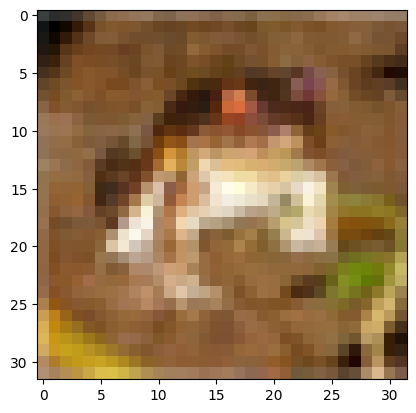

In [46]:
# 이미지를 시각화 해보자
plt.imshow(train_data.data[0])
plt.show()

In [47]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### 4) 배치 사이즈에 따른 데이터 분리 (Train, Test 데이터 만들기)

In [48]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_data, batch_size=32) 

In [49]:
data, label = next(iter(train_loader))
print(data[0].shape)

torch.Size([3, 32, 32])


### + 이미지 시각화

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

def view_img(tensor_image):
    img_data = tensor_image.numpy()

    # 이미지를 시각화 해보자
    plt.imshow(np.transpose(img_data, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.0591094].


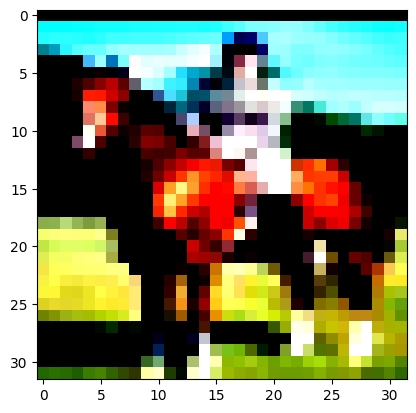

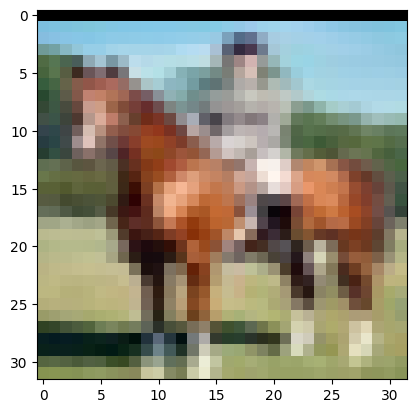

정답: horse


In [57]:
view_img(data[0])
view_img(denormalize(data[0], MEAN, STD))
print(f'정답: {train_data.classes[label[0].item()]}')

## 2. 모델 정의하기

In [ ]:
class BasicBloc(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBloc, self).__init__()

        # convolutions
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)  # (32 + 2 - 3 / 1) + 1 = 32
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1) # (32 + 2 - 3 / 1) + 1 = 32
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # ((32 - 2) / 2) + 1 = 16
    
    def forward(self, x):
        x = self.conv1(x)         
        x = self.relu(x)

        x = self.conv2(x)  
        x = self.relu(x)
        x = self.pool(x)

        return x

class Vgg16(nn.Module):
    def __init__(self, num_classes = 10):
        super(Vgg16, self).__init__()

        # convolutions
        # 3 * 32 * 32
        self.block1 = BasicBloc(in_channels=3, out_channels=32, hidden_dim=16)      # 32 * (16 * 16) = 4096
        self.block2 = BasicBloc(in_channels=32, out_channels=128, hidden_dim=64)    # 128 * (8 * 8) = 4096
        self.block3 = BasicBloc(in_channels=128, out_channels=256, hidden_dim=128)  # 256 * (4 * 4) = 4096

        self.relu = nn.ReLU()
        
        # fully connection
        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=256) 
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes) 

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)   
        x = self.relu(x)
        x = self.fc2(x)   
        x = self.relu(x)
        x = self.fc3(x)

        return x

model = Vgg16(10)

# 3. 모델 학습하기

In [80]:
from torch.utils.tensorboard import SummaryWriter
import tqdm

writer = SummaryWriter()

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

epochs = 20
step = 0
for epoch in range(epochs):
    for data, label in tqdm.tqdm(train_loader):
        optim.zero_grad() # 최적화 함수를 초기화 해야함 (한 번 학습시 마다)

        # 순전파
        preds = model(data.to(device))

        # 손실함수 계산
        loss = criterion(preds, label.to(device))

        # 역전파
        loss.backward()
        optim.step()

        # tensorboard에 데이터 추가
        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1
    
    print(f"{epoch + 1} loss : {loss.item()}")

100%|██████████| 1563/1563 [00:39<00:00, 39.28it/s]


1 loss : 1.1384074687957764


100%|██████████| 1563/1563 [00:41<00:00, 37.89it/s]


2 loss : 1.123612880706787


100%|██████████| 1563/1563 [00:38<00:00, 40.32it/s]


3 loss : 0.9820361137390137


100%|██████████| 1563/1563 [00:34<00:00, 45.73it/s]


4 loss : 0.88283371925354


100%|██████████| 1563/1563 [00:33<00:00, 47.06it/s]


5 loss : 0.9742412567138672


100%|██████████| 1563/1563 [00:36<00:00, 42.97it/s]


6 loss : 0.48743873834609985


100%|██████████| 1563/1563 [00:35<00:00, 44.06it/s]


7 loss : 0.8566716909408569


100%|██████████| 1563/1563 [00:32<00:00, 47.46it/s]


8 loss : 0.756506085395813


100%|██████████| 1563/1563 [00:31<00:00, 49.46it/s]


9 loss : 0.5108822584152222


100%|██████████| 1563/1563 [00:32<00:00, 47.68it/s]


10 loss : 0.9071144461631775


100%|██████████| 1563/1563 [00:34<00:00, 45.81it/s]


11 loss : 0.6412957906723022


100%|██████████| 1563/1563 [00:33<00:00, 46.38it/s]


12 loss : 0.5616764426231384


100%|██████████| 1563/1563 [00:42<00:00, 37.02it/s]


13 loss : 1.1199926137924194


100%|██████████| 1563/1563 [00:39<00:00, 39.23it/s]


14 loss : 0.8130017518997192


100%|██████████| 1563/1563 [00:35<00:00, 44.02it/s]


15 loss : 0.20558547973632812


100%|██████████| 1563/1563 [00:34<00:00, 45.47it/s]


16 loss : 0.2565467059612274


100%|██████████| 1563/1563 [00:36<00:00, 42.99it/s]


17 loss : 0.5091652870178223


100%|██████████| 1563/1563 [00:31<00:00, 48.94it/s]


18 loss : 0.673452615737915


100%|██████████| 1563/1563 [00:34<00:00, 44.91it/s]


19 loss : 0.596882164478302


100%|██████████| 1563/1563 [00:35<00:00, 44.29it/s]

20 loss : 0.10759005695581436


# 4. 모델 저장하기

In [82]:
import joblib

# 모델 저장
joblib.dump(model, 'models/number_image_vgg16_model.pkl')

['models/number_image_vgg16_model.pkl']

# + 모델을 불러와서 사용하기

In [83]:
from torchvision.models.vgg import vgg16

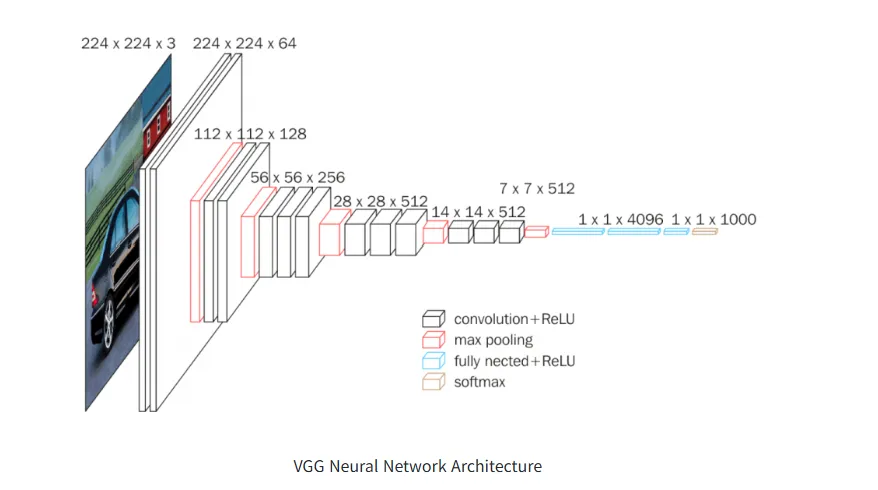

1. 내가 가진 데이터셋과 이미 학습된 데이터셋을 비교 > 비슷한 경우
2. 내가 가진 데이터셋이 많이 부족할경우 

-> 이미 학습된 가중치를 사용해보자

In [ ]:
vgg_model = vgg16(pretrained=True) # pretrained : imagenet 데이터로 이미 학습 된 가중치를 가져온다 
print(vgg_model)

c:\Potenup\DeepLearning-Study\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Potenup\DeepLearning-Study\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## ⭐ 분류 모델 부분만 바꾸기

내 데이터에 맞춰서 분류 모델 부분을 수정하는 것이 필요하다
- 분류할 클래스의 갯수가 다를 수 있다
- 분류할 데이터의 사이즈가 다를 수 있다

In [ ]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    # nn.Dropout(),
    nn.Linear(4096, 4096), 
    nn.ReLU(),
    # nn.Dropout(),
    nn.Linear(4096, 10),
)

vgg_model.classifier = fc
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1